##### Introduction

In this project, we aim to predict the traffic volume on I-94 Interstate highway using various features like weather conditions, time of the day, whether the day is a holiday or not, etc.


#### Data Collection

In this step, we will download the dataset from the provided Kaggle link and read the dataset description and other available metadata to understand the context of the data.


In [96]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

In [6]:
# Load the dataset
df = pd.read_csv("C:\\Users\\bhavana\\Downloads\\traffic_data\\Traffic_data_EDA\\cleaned_traffic_weather_event_data.csv")

In [7]:
# Display the first few rows of the DataFrame
df.head()

,DateTime,Junction,Vehicles,ID,temp,humidity,preciptype,windspeed,event_name,category,location,expected_traffic_impact
0,2015-11-01 00:00:00,1,15,20151101001,22.444444,71.7,Clear,12.8,,,,
1,2015-11-01 00:00:00,1,15,20151101001,22.444444,71.7,Clouds,12.8,,,,
2,2015-11-01 01:00:00,1,13,20151101011,22.444444,71.7,Clouds,12.8,,,,
3,2015-11-01 02:00:00,1,10,20151101021,22.444444,71.7,Clouds,12.8,,,,
4,2015-11-01 03:00:00,1,7,20151101031,22.444444,71.7,Clouds,12.8,,,,


In [9]:
df.shape

(48162, 12)

In [10]:
df.dtypes

DateTime                    object
Junction                     int64
Vehicles                     int64
ID                           int64
temp                       float64
humidity                   float64
preciptype                  object
windspeed                  float64
event_name                  object
category                    object
location                    object
expected_traffic_impact     object
dtype: object

In [12]:
# Check if event_name is missing or marked as 'None'
df['is_event'] = df['event_name'].apply(lambda x: 0 if pd.isna(x) or x in ['None', 'Unknown', ''] else 1)

In [14]:
df.shape

(48162, 13)

#### Exploratory Data Analysis (EDA)¶

In this step, we will perform an initial exploration of the data, check for missing values, perform statistical analysis, and visualize the data to understand the distribution and relationship between different variables.


In [16]:
df.isnull().sum()

DateTime                   0
Junction                   0
Vehicles                   0
ID                         0
temp                       0
humidity                   0
preciptype                 0
windspeed                  0
event_name                 0
category                   0
location                   0
expected_traffic_impact    0
is_event                   0
dtype: int64

In [17]:
# Perform statistical analysis
df.describe()

,Junction,Vehicles,ID,temp,humidity,windspeed,is_event
count,48162.000000,48162.000000,4.816200e+04,48162.000000,48162.000000,48162.000000,48162.000000
mean,2.180391,22.780221,2.016329e+10,24.452310,66.963916,12.640420,0.999190
std,0.966849,20.745460,5.953164e+06,2.152410,11.701424,3.547468,0.028445
min,1.000000,1.000000,2.015110e+10,19.777778,34.700000,5.900000,0.000000
25%,1.000000,9.000000,2.016042e+10,22.944444,58.100000,10.200000,1.000000
50%,2.000000,15.000000,2.016093e+10,24.333333,66.400000,11.500000,1.000000
75%,3.000000,29.000000,2.017023e+10,26.333333,76.500000,14.000000,1.000000
max,4.000000,180.000000,2.017063e+10,28.833333,89.800000,27.700000,1.000000



#### Data Visualization

Let's visualize the data to understand the distribution and relationship between different variables.


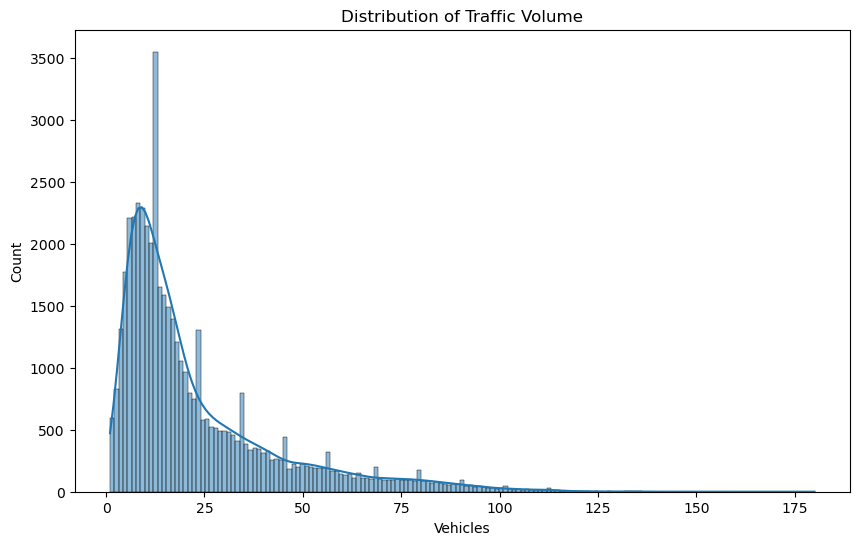

In [20]:
# Histogram of traffic volume
plt.figure(figsize=(10,6))
sns.histplot(df['Vehicles'], kde=True)
plt.title('Distribution of Traffic Volume')
plt.show()

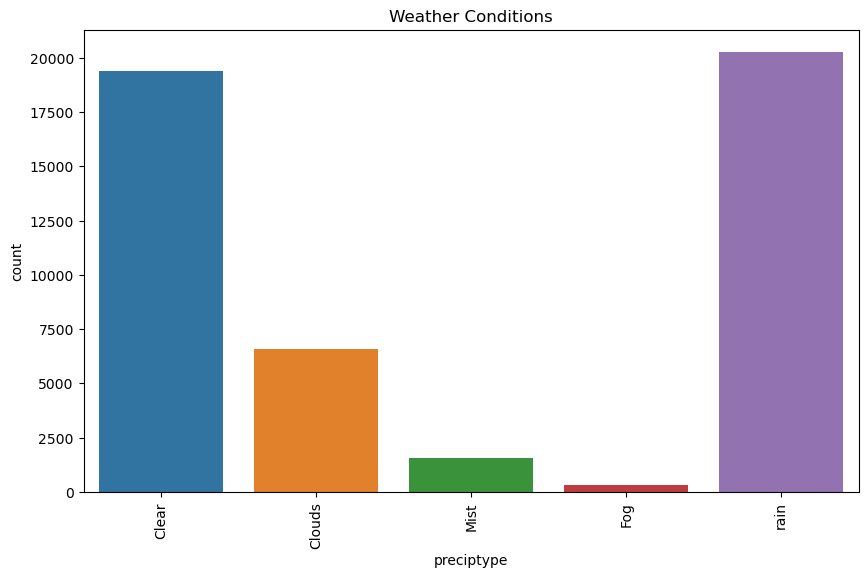

In [22]:
# Bar plot of weather_main
plt.figure(figsize=(10,6))
sns.countplot(x='preciptype', data=df)
plt.title('Weather Conditions')
plt.xticks(rotation=90)
plt.show()

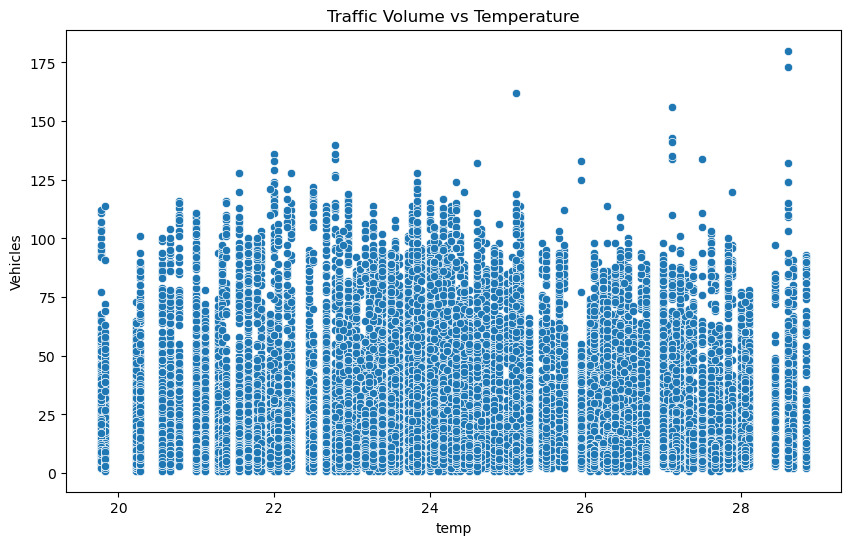

In [23]:
# Scatter plot of traffic_volume vs temp
plt.figure(figsize=(10,6))
sns.scatterplot(x='temp', y='Vehicles', data=df)
plt.title('Traffic Volume vs Temperature')
plt.show()

#### Feature Engineering

In this step, we will extract useful features from the 'date_time' column, convert categorical variables into numerical format, and normalize or standardize numerical features if required.

In [11]:
# convert to datetime type
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [27]:
# Extract features from 'date_time'
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['month'] = df['DateTime'].dt.month

In [28]:
# Convert categorical variables into numerical format using one-hot encoding
df = pd.get_dummies(df, columns=['preciptype','expected_traffic_impact'])

In [46]:
# Here, standardizing 'temp', 'rain_1h', 'snow_1h', and 'clouds_all'

# Define the columns to scale
cols_to_scale = ['temp', 'humidity', 'windspeed', 'Vehicles']

# Initialize the scaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [53]:
df.dtypes

DateTime                            datetime64[ns]
Junction                                     int64
Vehicles                                   float64
ID                                           int64
temp                                       float64
humidity                                   float64
windspeed                                  float64
event_name                                  object
category                                    object
location                                    object
is_event                                     int64
hour                                         int64
day_of_week                                  int64
month                                        int64
preciptype_Clear                             uint8
preciptype_Clouds                            uint8
preciptype_Fog                               uint8
preciptype_Mist                              uint8
preciptype_rain                              uint8
expected_traffic_impact_       


#### Model Selection

In this step, we will split the data into training and testing sets, choose a suitable model for regression tasks, and train the model on the training data.


In [55]:
# Define the features and the target
X = df.drop(['Vehicles', 'DateTime','event_name','category','location'], axis=1)
y = df['Vehicles']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#### Linear Regression¶

We will start with a simple Linear Regression model.


In [56]:
# Initialize the Linear Regression model
lr = LinearRegression()

# Train the model on the training data
lr.fit(X_train, y_train)


LinearRegression()

In [59]:
y_pred = lr.predict(X_test)


#### Model Evaluation¶

In this step, we will evaluate the model on the testing data using appropriate metrics like Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), or R-Squared Error.


In [60]:
# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 2. Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 3. R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0544
Root Mean Square Error (RMSE): 0.0736
R-squared (R²): 0.5990


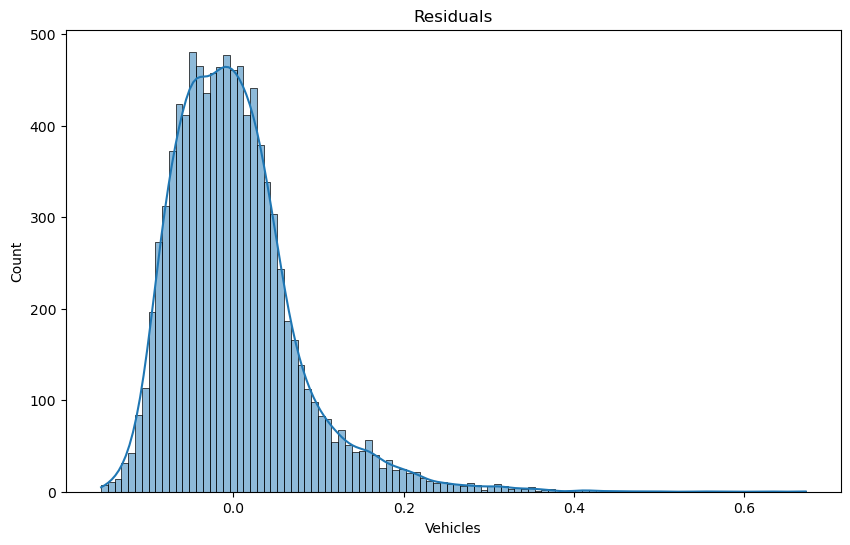

In [61]:
# Calculate residuals
residuals = y_test - y_pred

# Plot the residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Residuals')
plt.show()

In [85]:
print(df_clean.columns)
print(df_clean.index.name)

Index(['Junction', 'Vehicles', 'ID', 'temp', 'humidity', 'windspeed',
       'is_event', 'hour', 'day_of_week', 'month', 'preciptype_Clear',
       'preciptype_Clouds', 'preciptype_Fog', 'preciptype_Mist',
       'preciptype_rain', 'expected_traffic_impact_ ',
       'expected_traffic_impact_High', 'expected_traffic_impact_Low',
       'expected_traffic_impact_Moderate', 'expected_traffic_impact_None'],
      dtype='object')
DateTime


In [86]:
df = df_clean.sort_index()

In [77]:
 df['DateTime'].duplicated().sum()

33570

In [78]:
# Convert to datetime if not already
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Group and average to remove duplicates
df_clean = df.groupby('DateTime').mean().reset_index()

In [80]:
df_clean.set_index('DateTime', inplace=True)
df_clean = df_clean.sort_index()
df_clean = df_clean.resample('H').mean().fillna(method='ffill')

In [87]:
df_clean = df_clean.reset_index()  # Only needed if 'DateTime' is currently the index
df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'])  # Ensure it's datetime
df_clean = df_clean.groupby('DateTime').mean().reset_index()  # Remove duplicates
df = df_clean.set_index('DateTime').sort_index()
df = df.resample('H').mean().fillna(method='ffill')  # Resample to hourly

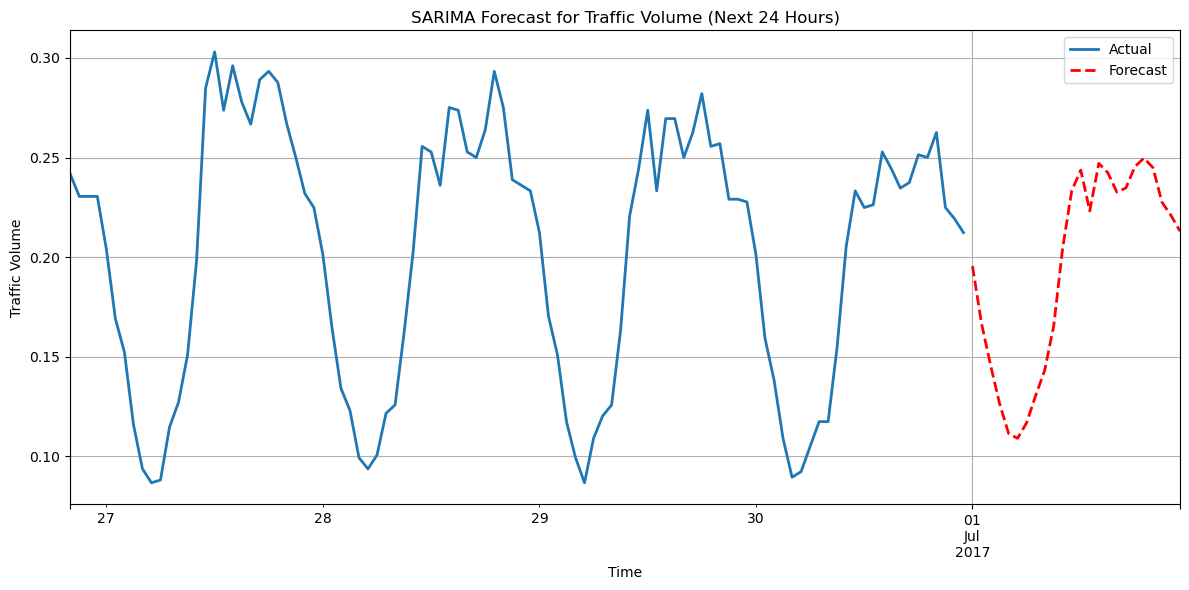

In [88]:

# Step 4: Create univariate time series
ts = df['Vehicles']

# Step 5: Fit SARIMA model
model = SARIMAX(ts, order=(1,1,1), seasonal_order=(1,1,1,24))
results = model.fit(disp=False)  # disp=False suppresses verbose output

# Step 6: Forecast next 24 hours
forecast = results.forecast(steps=24)

# Step 7: Plot results
plt.figure(figsize=(12,6))
ts[-100:].plot(label='Actual', linewidth=2)
forecast.plot(label='Forecast', color='red', linestyle='--', linewidth=2)
plt.legend()
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('SARIMA Forecast for Traffic Volume (Next 24 Hours)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [75]:
print(df.columns)

Index(['Junction', 'Vehicles', 'ID', 'temp', 'humidity', 'windspeed',
       'event_name', 'category', 'location', 'is_event', 'hour', 'day_of_week',
       'month', 'preciptype_Clear', 'preciptype_Clouds', 'preciptype_Fog',
       'preciptype_Mist', 'preciptype_rain', 'expected_traffic_impact_ ',
       'expected_traffic_impact_High', 'expected_traffic_impact_Low',
       'expected_traffic_impact_Moderate', 'expected_traffic_impact_None'],
      dtype='object')


In [76]:
df = df.reset_index()

Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0120 - val_loss: 0.0195
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 10/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0010 - val_loss: 0.0013
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


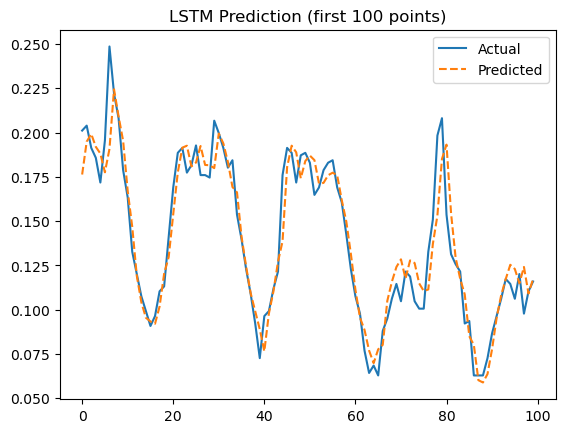

In [69]:
# Only time series of 'Vehicles'
data = df[['DateTime', 'Vehicles']].copy()
data.set_index('DateTime', inplace=True)
data = data.resample('H').mean().fillna(method='ffill')

# Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 24  # 24 hours
X, y = create_sequences(data_scaled, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# LSTM Model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Evaluate
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.plot(y_test_inv[:100], label='Actual')
plt.plot(y_pred_inv[:100], label='Predicted', linestyle='--')
plt.legend()
plt.title('LSTM Prediction (first 100 points)')
plt.show()

In [70]:
# 1. Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# 2. Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 3. R-squared (R²)
r2 = r2_score(y_test, y_pred)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.0254
Root Mean Square Error (RMSE): 0.0364
R-squared (R²): 0.9060


In [91]:
# Define features and target
features = ['temp', 'humidity', 'windspeed', 'hour', 'day_of_week', 'month', 'is_event'] + \
           [col for col in df.columns if 'preciptype_' in col or 'expected_traffic_impact_' in col]

X = df[features]
y = df['Vehicles']

# Use TimeSeriesSplit for time-based CV
tscv = TimeSeriesSplit(n_splits=3)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=tscv, scoring='neg_root_mean_squared_error', verbose=1, n_jobs=-1)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (neg):", grid_search.best_score_)



Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best RMSE (neg): -0.05361280221916911


In [94]:
## Evaluate Model Performance (on Validation Set)

# Predict using best XGBoost model
y_pred = grid_search.best_estimator_.predict(X)

# Create DataFrame for evaluation
eval_df = df.copy()
eval_df['Predicted'] = y_pred
eval_df['Residual'] = eval_df['Vehicles'] - eval_df['Predicted']

# Evaluation Metrics
mae = mean_absolute_error(eval_df['Vehicles'], eval_df['Predicted'])
rmse = mean_squared_error(eval_df['Vehicles'], eval_df['Predicted'], squared=False)
r2 = r2_score(eval_df['Vehicles'], eval_df['Predicted'])

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}"

)





MAE: 0.0193
RMSE: 0.0251
R²: 0.7916


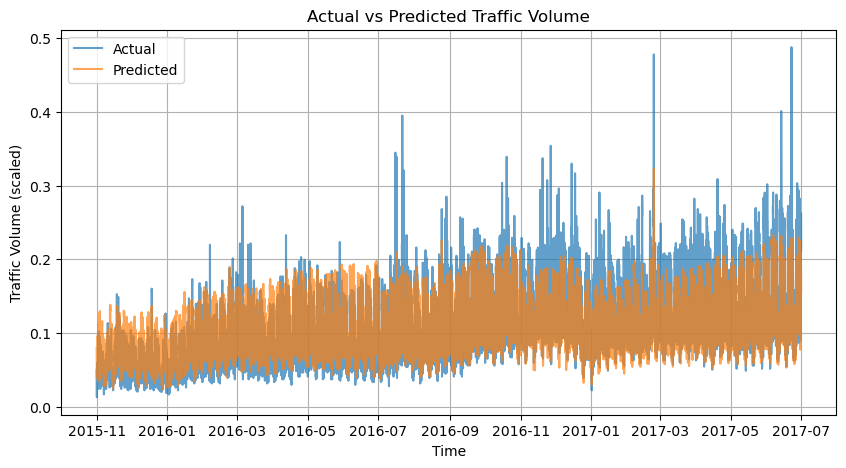

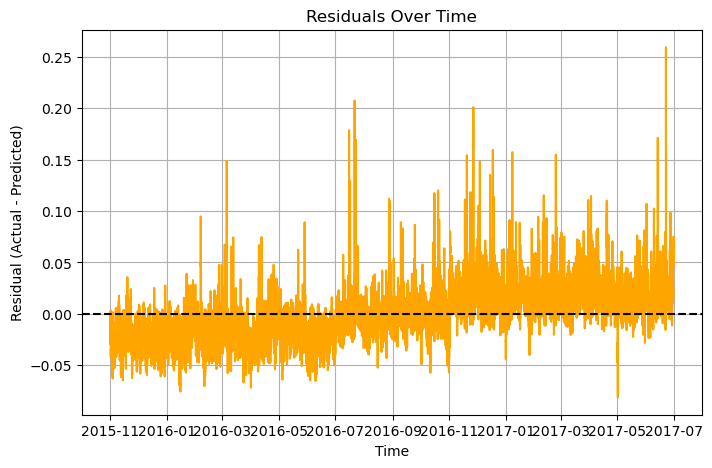

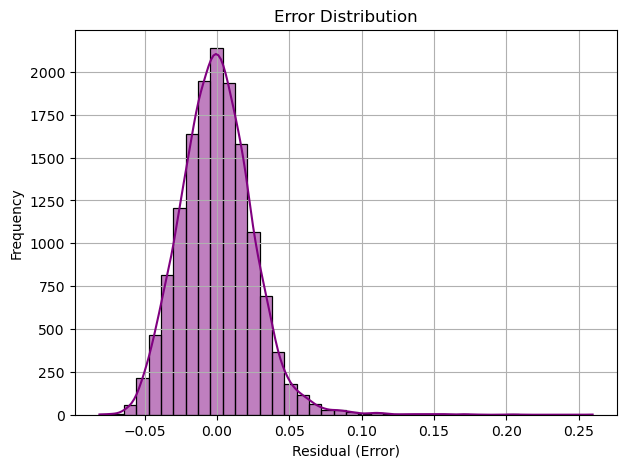

In [95]:
# Visualizations:

# 1. Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(eval_df.index, eval_df['Vehicles'], label='Actual', alpha=0.7)
plt.plot(eval_df.index, eval_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Traffic Volume')
plt.xlabel('Time')
plt.ylabel('Traffic Volume (scaled)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Residual Plot
plt.figure(figsize=(8, 5))
plt.plot(eval_df.index, eval_df['Residual'], color='orange')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residual (Actual - Predicted)')
plt.axhline(0, linestyle='--', color='black')
plt.grid(True)
plt.show()

# 3. Error Distribution
plt.figure(figsize=(7, 5))
sns.histplot(eval_df['Residual'], kde=True, bins=40, color='purple')
plt.title('Error Distribution')
plt.xlabel('Residual (Error)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [98]:
## . Cross-Validation with TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
fold = 1
results = []

for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    model = xgb.XGBRegressor(**grid_search.best_params_)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)
    fold_mae = mean_absolute_error(y_val, y_pred)
    fold_rmse = mean_squared_error(y_val, y_pred, squared=False)
    fold_r2 = r2_score(y_val, y_pred)

    print(f"Fold {fold}: MAE={fold_mae:.4f}, RMSE={fold_rmse:.4f}, R²={fold_r2:.4f}")
    results.append((fold_mae, fold_rmse, fold_r2))
    fold += 1

Fold 1: MAE=0.0236, RMSE=0.0320, R²=0.4283
Fold 2: MAE=0.0559, RMSE=0.0684, R²=-0.9607
Fold 3: MAE=0.0528, RMSE=0.0607, R²=-0.2002



Cross-validation summary:
            MAE      RMSE        R2
count  3.000000  3.000000  3.000000
mean   0.044092  0.053718 -0.244193
std    0.017850  0.019180  0.695531
min    0.023562  0.032027 -0.960692
25%    0.038165  0.046358 -0.580428
50%    0.052768  0.060690 -0.200164
75%    0.054357  0.064563  0.114057
max    0.055946  0.068437  0.428277


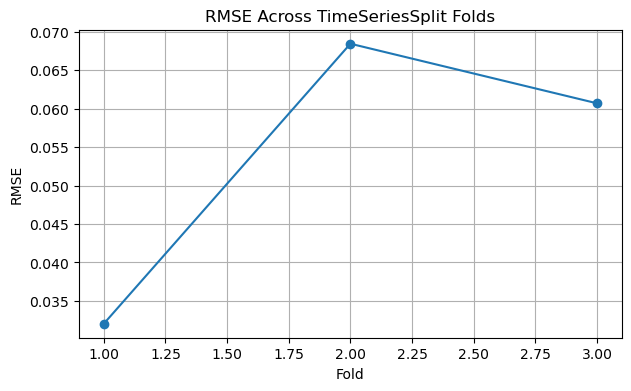

In [99]:
# 3. Analyze Cross-Validation Results

# Convert results to DataFrame
cv_results = pd.DataFrame(results, columns=['MAE', 'RMSE', 'R2'])

# Summary
print("\nCross-validation summary:")
print(cv_results.describe())

# Plot fold-wise RMSE
plt.figure(figsize=(7, 4))
plt.plot(range(1, 4), cv_results['RMSE'], marker='o')
plt.title('RMSE Across TimeSeriesSplit Folds')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

#### Model Refinement

Diagnose model issues:
Use insights from evaluation and cross-validation to identify weaknesses in the models (e.g., high bias, high variance).
Perform error analysis to understand the types of errors the model is making (e.g., systematic errors, random noise).


<Axes: title={'center': 'Validation RMSE across folds'}>

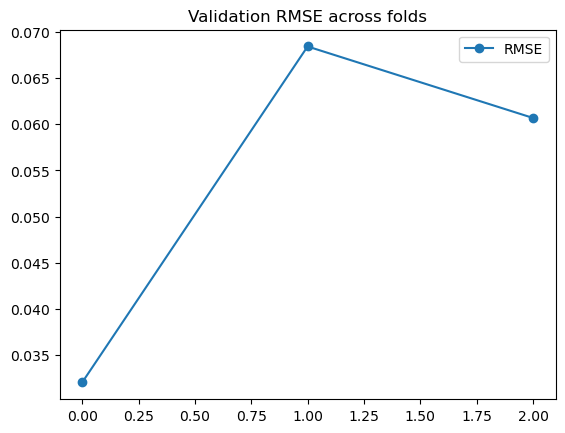

In [100]:
cv_results.plot(y='RMSE', marker='o', title='Validation RMSE across folds')

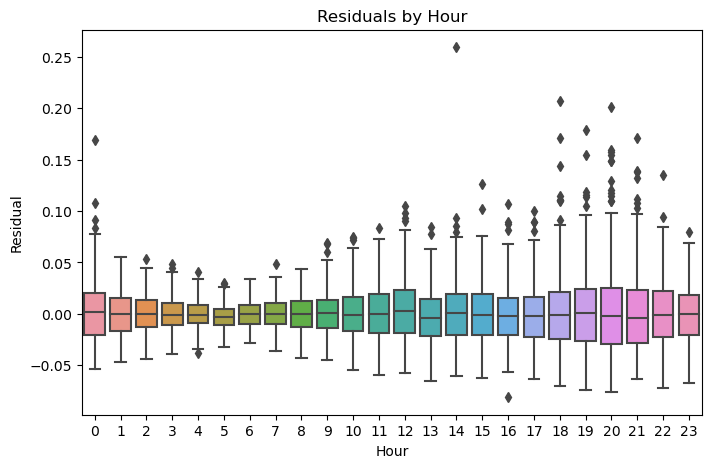

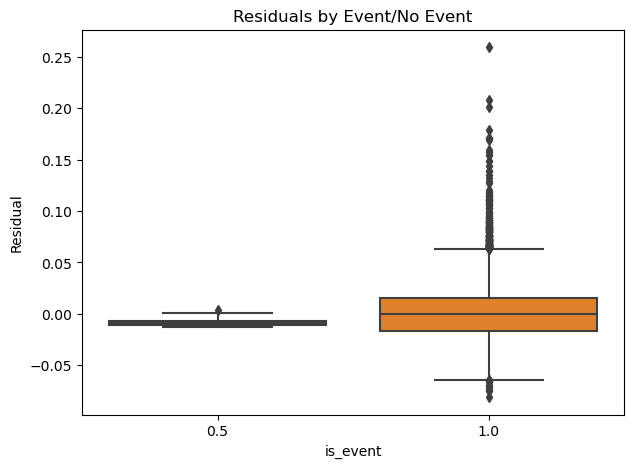

In [102]:
#Error Analysis

# plots of error by time, by event, or by traffic impact:

# Error by time of day
df['Hour'] = df.index.hour
df['Residual'] = df['Vehicles'] - eval_df['Predicted']

plt.figure(figsize=(8,5))
sns.boxplot(x='Hour', y='Residual', data=df)
plt.title('Residuals by Hour')
plt.show()

# Error by event presence
plt.figure(figsize=(7,5))
sns.boxplot(x='is_event', y='Residual', data=df)
plt.title('Residuals by Event/No Event')
plt.show()

###### Improve Model Features & Algorithms
🔧 A. Refine Feature Engineering

    Add lag features: e.g., Vehicles(t-1), Vehicles(t-24)

    Add rolling statistics: mean_1h, mean_24h, std_6h, etc.

    Use holiday/event flags, one-hot encoded

In [103]:
# Example: lag and rolling mean
df['lag1'] = df['Vehicles'].shift(1)
df['mean_24h'] = df['Vehicles'].rolling(window=24).mean()
df = df.dropna()

In [104]:
# Hyperparameter Tuning: Randomized Search

# More efficient than GridSearch if you have many parameters:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3)
}

random_search = RandomizedSearchCV(xgb.XGBRegressor(), param_distributions=param_dist,
                                   n_iter=30, scoring='neg_root_mean_squared_error',
                                   cv=TimeSeriesSplit(n_splits=3), verbose=1, random_state=42)

random_search.fit(X, y)
print("Best params:", random_search.best_params_)



Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best params: {'learning_rate': 0.1784569549189997, 'max_depth': 6, 'n_estimators': 63, 'subsample': 0.9181815987569262}
